In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import scipy as sp
from scipy import interpolate, signal
import random
import pandas as pd
import warnings
from cycler import cycler
from siggen_pulses import *
from oneshot import *
import matplotlib

%matplotlib inline

In [3]:
# print(plt.rcParams)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rcParams.update(params)

In [4]:
# Plotting settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana',
                                   'Computer Modern Sans Serif',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Lucida Grande',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',
                                   'Helvetica',
                                   'Avant Garde',
                                   'sans-serif']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.prop_cycle'] = (cycler(color=['r', 'g', 'b', 'y']) + 
                                   cycler(linestyle=['-', '--', ':', '-.']))
# font = {'family': 'sans-serif',
#         'fantasy': 'xkcd',
# #         'sans-serif': 'arial',
#        'weight':'normal',
#        'size':20}
# rc('font', **font)

# matplotlib.rc('xtick', labelsize=20)
# matplotlib.rc('ytick', labelsize=20)

<h1>ToF Histogram</h1>

In [20]:
file_name = '../data/tofs.csv'
tof_col_name = 'TOF[ns]'
mq_names = ['MQ{0}'.format(x) for x in (1,2,4,14,16,18,20,28,29,30,38,39,40)]
# data = pd.read_csv(file_name)
data_dict = parse_tof_histogram(file_name, tof_col_name, mq_names)

In [21]:
data = pd.read_csv(file_name)
times = list(data[tof_col_name])
mq_distrib_dict = {mq:data[mq] for mq in mq_names}

C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


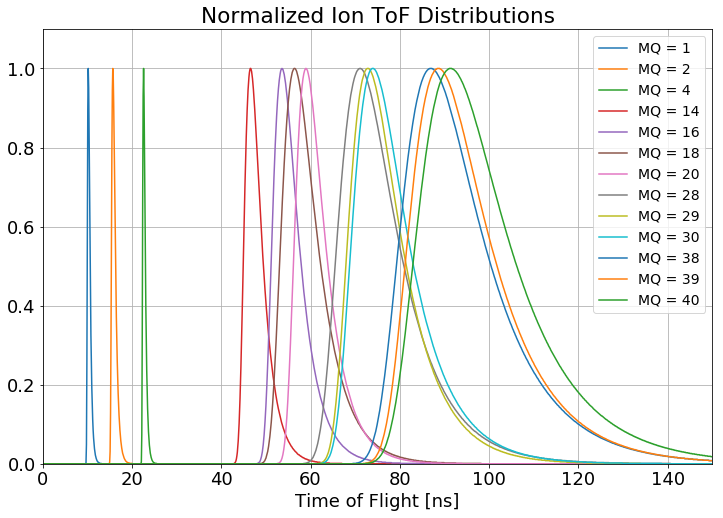

In [32]:
# Settings
ylim = (0, 1.1)
xlim = (min(times), 150)
figsize = (12, 8)
mq_styles = ['r-', 'g.']

# Plotting
fig, ax = plt.subplots(figsize=figsize)
for i, mq in enumerate(mq_names):
    # Histograms
    mq_value = mq.replace('MQ', '')
    mq_label = f'MQ = {mq_value}'
    mq_distrib = mq_distrib_dict[mq]
    ax.plot(times, mq_distrib, label=mq_label)
    
    # Annotate peak of histogram with MQ
#     mq_annot = mq
#     idx_peak = np.argmax(mq_distrib)
#     y_peak = max(mq_distrib)
#     x_peak = times[idx_peak]
#     loc_annot = (x_peak, y_peak*1.05)
#     ax.annotate(s=mq_annot, xy=loc_annot)
    
ax.legend()
ax.set_xlabel('Time of Flight [ns]')
ax.set_title('Normalized Ion ToF Distributions')
ax.grid(True)
ax.set_ylim(ylim)
ax.set_xlim(xlim);

<h1>One-Shot Results Statistics</h1>

In [36]:
file_names = ['../data/1p8/data_1nsPulse_randPeriod_R10kC1p_yesReset.csv', 
              '../data/1p8/data_1nsPulse_randPeriod_R20kC1p_yesReset.csv',
              '../data/1p8/data_1nsPulse_randPeriod_R30kC1p_yesReset.csv',
              '../data/1p8/data_1nsPulse_randPeriod_R40kC1p_yesReset.csv']
data_dicts = [parse_pulse(file_name) for file_name in file_names]

pulse_widths_specs = [dict(data_dict = data_dict,
                          sig_threshold = 0.9,
                          posedge = True) for data_dict in data_dicts]
pulse_widths_lists = [get_pulse_widths(**pulse_widths_spec) for pulse_widths_spec in pulse_widths_specs]

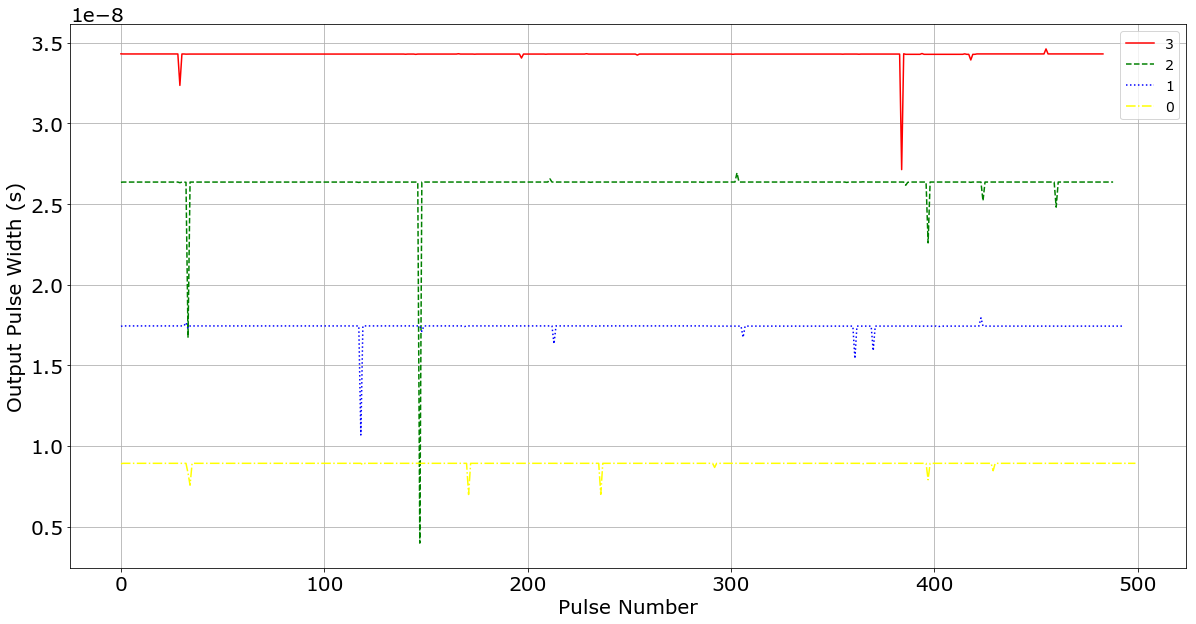

In [53]:
# Plotting
figsize = (20, 10)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(pulse_widths_lists[0], 'red', label='3')
ax.plot(pulse_widths_lists[1], 'green', label='2')
ax.plot(pulse_widths_lists[2], 'blue', label='1')
ax.plot(pulse_widths_lists[3], 'yellow', label='0')

ax.set_xlabel('Pulse Number')
ax.set_ylabel('Output Pulse Width (s)')
ax.legend()
# ax.set_title(f'Mean = {np.average(pulse_width_list)*1e9} ns\nStdDev = {np.std(pulse_width_list)*1e9} ns')
ax.grid(True)

Text(0.5,1,'One-Shot Output Pulse Width Distribution\nPulse Width = 1ns, Pulse Spacing = [10, 1000]ns, Randomly Sampled')

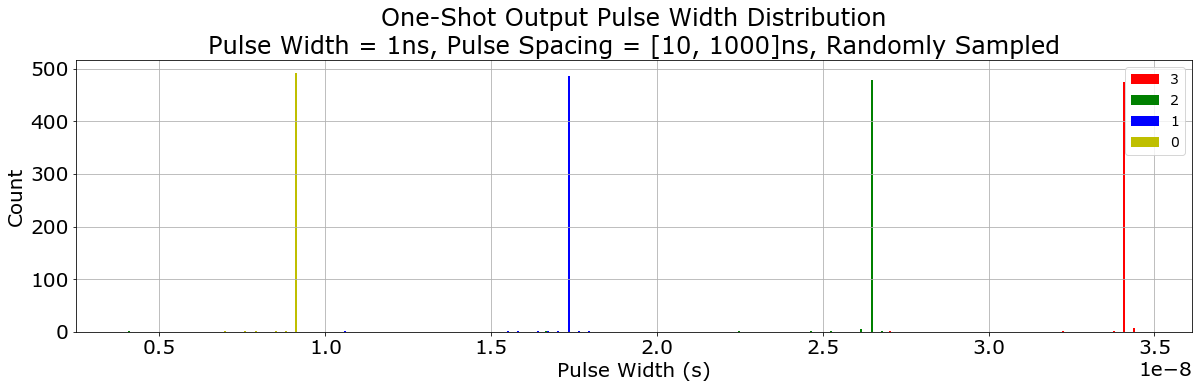

In [52]:
# Histogram
figsize = (20, 5)
num_bins = 100

fig, ax = plt.subplots(figsize=figsize)
# ax.hist(pulse_width_list, bins=100)
ax.hist(pulse_widths_lists, bins=num_bins, label=['3', '2', '1', '0'])
# ax.hist(pulse_widths_lists[0], color='red', bins=num_bins, alpha=1, label='3')
# ax.hist(pulse_widths_lists[1], color='green', bins=num_bins, alpha=1, label='2')
# ax.hist(pulse_widths_lists[2], color='blue', bins=num_bins, alpha=1, label='1')
# ax.hist(pulse_widths_lists[3], color='black', bins=num_bins, alpha=1, label='0')
ax.set_xlabel('Pulse Width (s)')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True)
ax.set_title('One-Shot Output Pulse Width Distribution\nPulse Width = 1ns, Pulse Spacing = [10, 1000]ns, Randomly Sampled')
# ax.set_title('Pulse Width = 1ns\nPulse Spacing = [1, 100]ns, Randomly Sampled')

In [42]:
pulse_widths_lists[3]

[8.891003190430458e-09,
 8.920386443665244e-09,
 8.920385883519074e-09,
 8.920385881531087e-09,
 8.920385892189303e-09,
 8.92038588268644e-09,
 8.92038601342894e-09,
 8.92038588213714e-09,
 8.920386379674128e-09,
 8.920385885908977e-09,
 8.92038588404381e-09,
 8.9203858861453e-09,
 8.920386556580347e-09,
 8.920385882883375e-09,
 8.92038588214815e-09,
 8.920383858644038e-09,
 8.920385881746657e-09,
 8.920385881792397e-09,
 8.920385881746657e-09,
 8.920386576137491e-09,
 8.920385881482383e-09,
 8.920385892046578e-09,
 8.920385891033526e-09,
 8.920385885249985e-09,
 8.920385884848492e-09,
 8.920385884392788e-09,
 8.920385904757154e-09,
 8.9203859084553e-09,
 8.9203858839896e-09,
 8.92059373448057e-09,
 8.920385878544873e-09,
 8.920386273885642e-09,
 8.92038454938416e-09,
 8.313786945670168e-09,
 7.563172298192405e-09,
 8.920380707994876e-09,
 8.920410033559612e-09,
 8.920409603727661e-09,
 8.920409618591395e-09,
 8.920409603609076e-09,
 8.920410110805629e-09,
 8.920409608477822e-09,
 8.92

<h2>Checking Bode Plot of Folded Cascode vs. Sim</h2>

In [14]:
num = np.array([-3.53895594e-004, -4.70738415e+007,  1.50356235e+019,
        2.47926605e+030,  1.59517475e+041,  5.75769776e+051,
        1.30387570e+062,  1.93756258e+072,  1.91312015e+082,
        1.24175010e+092,  5.11668364e+101,  1.24882971e+111,
        1.58562663e+120,  8.12989223e+128,  5.24596567e+136])
den = np.array([1.00000000e+000, 1.48311234e+011, 9.64486755e+021, 3.62458359e+032,
       8.73205029e+042, 1.41372736e+053, 1.56752525e+063, 1.18986463e+073,
       6.07158733e+082, 2.00068022e+092, 3.95710939e+101, 4.14370181e+110,
       1.90680507e+119, 2.22072378e+127, 7.55724493e+134])

s1 = signal.lti(num, den)
w, mag, phase = s1.bode()

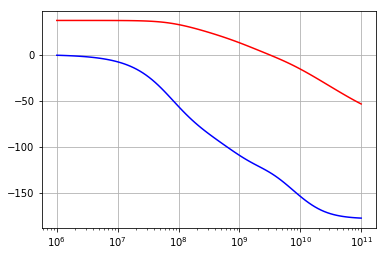

In [16]:
plt.figure()
plt.semilogx(w, mag, 'r')
plt.semilogx(w, phase, 'b')
plt.grid(True)

In [30]:
print(mag[69])
print(phase[69])

-0.04822475112617932
3.0538555088334123
-126.91679512124136
